In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.datasets as sd
import sklearn.model_selection as ms
import scipy.linalg as sl
import numpy as np
import PIL
np.set_printoptions(linewidth=120)

# Load MNIST data
Each image is represented by a 28 by 28 array of unsigned ints (0-255)

In [77]:
mnist = sd.fetch_mldata("MNIST original")
data, target = mnist.data, mnist.target


split data in to training set (60,000 observations) and testing set (10,000)

In [5]:
data_train, data_test, target_train, target_test = ms.train_test_split(data, target, train_size=60000, 
                                                                       test_size=10000, stratify=target)

## Display a few sample digits

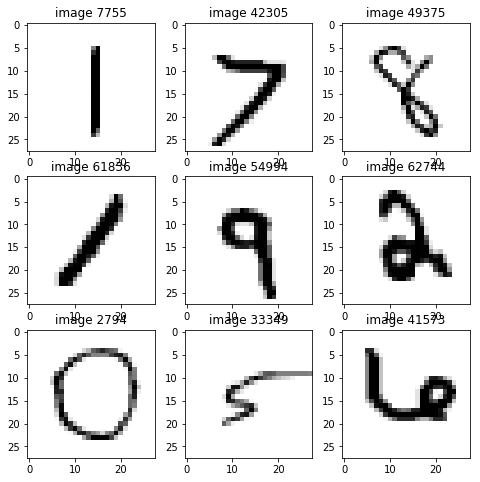

In [101]:
fig, axes = plt.subplots(3, 3, figsize=(8,8))
sample_images = [ 7755, 42305, 49375, 61836, 54994, 62744, 2794, 33349, 41573 ]
for i in range(3):
    for j in range(3):
        index = sample_images[i*3 + j]
        img = data[index].reshape(28, 28)
        ax = axes[i][j]
        ax.imshow(img, cmap=plt.cm.gray_r)
        ax.set_title('image {}'.format(index))
        

## Test a simple model
We'll use a gradient descent classifier here because of its speed, eventhough there are models that perform better for classification.

In [114]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier()

In [115]:
clf.fit(data_train, target_train)

/anaconda3/envs/notebook/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [116]:
clf.score(data_test, target_test)

0.8862

In [117]:
clf.score(data_train, target_train)

0.8971666666666667

# Preprocessing
## Deskew image
First, we'll write a function for finding the bounding box of each image

In [97]:
def find_bbox(img):
    """
    Finding bounding box of image
    
    Returns:
    min_col, max_col, min_row, max_row
    
    """
    img = img.astype(float)
    cols = np.any(img, axis=0)
    rows = np.any(img, axis=1)
    
    min_col, max_col = np.where(cols)[0][[0, -1]]
    min_row, max_row = np.where(rows)[0][[0, -1]]
    
    return min_col, max_col, min_row, max_row

def plot_bbox(img, ax=None):
    """
    Plot bounding box for an image
    """
    if not ax:
        fig, ax = plt.subplots()

    min_col, max_col, min_row, max_row = find_bbox(img)
    ax.imshow(img, cmap=plt.cm.gray_r)
   
    ax.axvline(min_col, color='r')
    ax.axvline(max_col, color='r')
    ax.axhline(min_row, color='r')
    ax.axhline(max_row, color='r')

    return ax
    

Test out bounding box on samples images from earlier.  Note that imshow() draws pixels cetered at given coordinates, so bounding boxes appear to overlap with digits, but that's fine for our purpose.

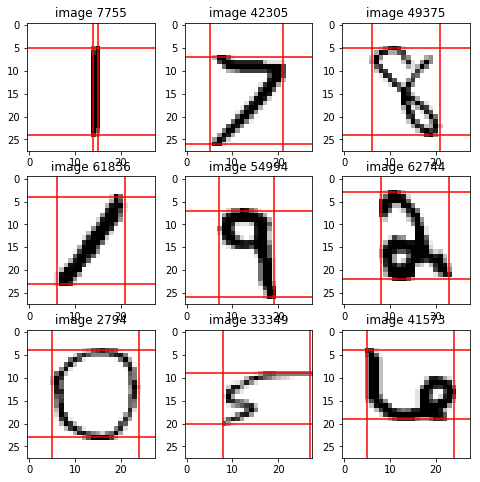

In [100]:
fig, axes = plt.subplots(3, 3, figsize=(8,8))
sample_images = [ 7755, 42305, 49375, 61836, 54994, 62744, 2794, 33349, 41573 ]
for i in range(3):
    for j in range(3):
        index = sample_images[i*3 + j]
        img = data[index].reshape(28, 28)
        ax = axes[i][j]
        plot_bbox(img, ax=ax)
        ax.set_title('image {}'.format(index))


Now try to determine if an image is rotated.  There are many fancy ways of trying to determine if an image is skewed (eg, https://en.wikipedia.org/wiki/Image_moment#Raw_moments).  Here, we'll keep things simple and look for a rotation that yields a bounding box with the max height to width ratio.

In [120]:
def find_bbox_dimensions(img):
    """
    Return bbox dimensions for image
    
    Returns
    height, width
    
    """
    min_col, max_col, min_row, max_row = find_bbox(img)
    height = max_row - min_row
    width = max_col - min_col
    
    return height, width

def rotate_image(img, angle=0):
    """
    Rotate image by angle
    
    """
    if angle == 0:
        return img
    
    pimg = PIL.Image.fromarray(img)
    pimg = pimg.rotate(angle, resample=PIL.Image.BILINEAR)
    img = np.array(pimg)

    return img
        
def find_best_bbox_angle(img, min_angle=-45, max_angle=45, angle_step=5):
    """
    Find angle that results in a bbox with the highest height to width ratio
    
    """
    res = dict()
    for angle in range(min_angle, max_angle + angle_step, angle_step):
        rotated = rotate_image(img, angle)
        height, width = find_bbox_dimensions(rotated)
        res[angle] = height / width
    
    best_angle = max(res, key=res.get)
    
    # don't bother rotating if best angle is not much better than no rotation
    if (res[best_angle] / res[0]) < 1.1:
        best_angle = 0

    return best_angle

def deskew_image(img):
    """
    Deskew an image by finding angle that maximizes image's height to width ratio
    """
    best_angle = find_best_bbox_angle(img)
    deskewed_image = rotate_image(img, best_angle)
    
    return deskewed_image


Now let's see sample images look after we "deskew" them

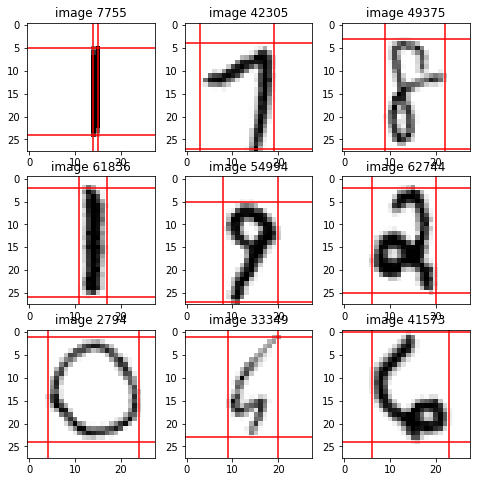

In [121]:
fig, axes = plt.subplots(3, 3, figsize=(8,8))
sample_images = [ 7755, 42305, 49375, 61836, 54994, 62744, 2794, 33349, 41573 ]
for i in range(3):
    for j in range(3):
        ax = axes[i][j]
        index = sample_images[i*3 + j]
        img = data[index].reshape(28, 28)

        plot_bbox(deskew_image(img), ax=ax)
        ax.set_title('image {}'.format(index))

In [ ]:
preprocessed_train = [ center_bbox(deskew_image(img.reshape(28,28))).reshape(-1) for img in data_train ]
preprocessed_test =  [ center_bbox(deskew_image(img.reshape(28,28))).reshape(-1) for img in data_test ]

In [128]:
clf.fit(preprocessed_train, target_train)
clf.score(preprocessed_test, target_test)


/anaconda3/envs/notebook/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.8419

In [129]:
predict_train = clf.predict(preprocessed_train)

In [138]:
errors_train = np.where(predict_train != target_train)[0]
len(errors_train)
print(target_train[errors_train[0]])
predict_train[errors_train[0]]

9.0


7.0

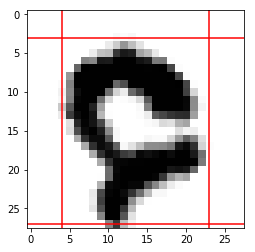

In [153]:
img = preprocessed_train[errors_train[0]].reshape(28, 28)
plot_bbox(img)

## Recenter image based on bounding box

In [154]:
find_bbox_dimensions(img)

def center_bbox(img, desired_height=28, desired_width=28):
    """
    Center an image's bbox
    
    """
    min_col, max_col, min_row, max_row = find_bbox(img)
    height = max_row - min_row
    width = max_col - min_col
    
    new_image = np.zeros((desired_height, desired_width))
    top = int(np.floor((desired_height - height) / 2))
    left = int(np.floor((desired_width - width) / 2))
    new_image[top:top+height, left:left+width] = img[min_row:max_row, min_col:max_col]
    
    return new_image
    

In [150]:
clf.predict(center_bbox(img).reshape(1, -1))

2
4


array([7.])

# Data augmentation

In [ ]:
import PIL

In [ ]:
sample = data_train[34222].reshape(28, 28)
img = PIL.Image.fromarray(sample)
plt.imshow(img)

In [ ]:
plt.imshow(sample)

In [ ]:
angle = determine_image_skew(sample)
angle

In [ ]:
angle

In [ ]:
plt.imshow(sample)


In [ ]:
plt.imshow(deskew_image(deskew_image(sample)))